In [1]:
import numpy as np
import torch
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

In [47]:
import pdb

In [2]:
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import pandas as pd

In [3]:
import io
import requests
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv'
titanic_data = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))

In [216]:
original_titatic_data = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))

In [217]:
original_titatic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [6]:
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [222]:
test_names = original_titatic_data['name'].values[test_indices]

In [107]:
titanic_data

,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,29.000000,0,0,211.3375,1,0,0,0,1,1,0,0
1,0.920000,1,2,151.5500,0,1,0,0,1,1,0,0
2,2.000000,1,2,151.5500,1,0,0,0,1,1,0,0
3,30.000000,1,2,151.5500,0,1,0,0,1,1,0,0
4,25.000000,1,2,151.5500,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,14.500000,1,0,14.4542,1,0,1,0,0,0,0,1
1305,29.881138,1,0,14.4542,1,0,1,0,0,0,0,1
1306,26.500000,0,0,7.2250,0,1,1,0,0,0,0,1
1307,27.000000,0,0,7.2250,0,1,1,0,0,0,0,1


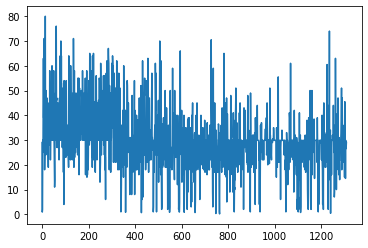

In [7]:
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 8)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 6)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(6, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [8]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('models/titanic_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'models/titanic_model.pt')

Epoch 1/200 => Loss: 0.68
Epoch 21/200 => Loss: 0.54
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.48
Epoch 181/200 => Loss: 0.48


In [9]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8286026200873362


In [10]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
test_input_tensor.requires_grad_(False)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.806615776081425


In [105]:
len(out_classes)

393

In [101]:
out_classes.sum()

112

In [103]:
len(out_classes) - out_classes.sum()

281

# Generate data for individual input, output, instance

In [120]:
model_config = {'input': 12, 'sigmoid1': 8, 'sigmoid2': 6, 'output': 2}

In [121]:
test_input_tensor.shape

torch.Size([393, 12])

In [125]:
net

TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=8, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=6, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [126]:
neuron_values = {}
net.eval()
with torch.no_grad():
    # Input
    neuron_values['input'] = test_input_tensor.detach().numpy()
    # layer 1 output
    sigmoid1_output = net.sigmoid1(net.linear1(test_input_tensor))
    neuron_values['sigmoid1'] = sigmoid1_output.detach().numpy()
    # layer 2 output
    sigmoid2_output = net.sigmoid2(net.linear2(sigmoid1_output))
    neuron_values['sigmoid2'] = sigmoid2_output.detach().numpy()
    # layer 3 output
    output = net.softmax(net.linear3(sigmoid2_output))
    neuron_values['output'] = output.detach().numpy()

In [433]:
baseline = test_input_tensor.detach().numpy().mean(axis=0)

In [436]:
feature_names

['age',
 'sibsp',
 'parch',
 'fare',
 'female',
 'male',
 'embark_C',
 'embark_Q',
 'embark_S',
 'class_1',
 'class_2',
 'class_3']

In [435]:
baseline

array([29.737814  ,  0.55979645,  0.38931298, 30.174593  ,  0.33333334,
        0.6666667 ,  0.21119593,  0.10687023,  0.6819338 ,  0.21119593,
        0.21882951,  0.56997454], dtype=float32)

In [11]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

In [354]:
def integrated_gradients_with_predictions(inp, target_label_index, predictions_and_gradients, baseline=None, steps=50):
    """Computes integrated gradients for a given network and prediction label.
      Integrated gradients is a technique for attributing a deep network's
      prediction to its input features. It was introduced by:
      https://arxiv.org/abs/1703.01365
      In addition to the integrated gradients tensor, the method also
      returns some additional debugging information for sanity checking
      the computation. See sanity_check_integrated_gradients for how this
      information is used.

      This method only applies to classification networks, i.e., networks 
      that predict a probability distribution across two or more class labels.

      Access to the specific network is provided to the method via a
      'predictions_and_gradients' function provided as argument to this method.
      The function takes a batch of inputs and a label, and returns the
      predicted probabilities of the label for the provided inputs, along with
      gradients of the prediction with respect to the input. Such a function
      should be easy to create in most deep learning frameworks.

      Args:
        inp: The specific input for which integrated gradients must be computed.
        target_label_index: Index of the target class for which integrated gradients
          must be computed.
        predictions_and_gradients: This is a function that provides access to the
          network's predictions and gradients. It takes the following
          arguments:
          - inputs: A batch of tensors of the same same shape as 'inp'. The first
              dimension is the batch dimension, and rest of the dimensions coincide
              with that of 'inp'.
          - target_label_index: The index of the target class for which gradients
            must be obtained.
          and returns:
          - predictions: Predicted probability distribution across all classes
              for each input. It has shape <batch, num_classes> where 'batch' is the
              number of inputs and num_classes is the number of classes for the model.
          - gradients: Gradients of the prediction for the target class (denoted by
              target_label_index) with respect to the inputs. It has the same shape
              as 'inputs'.
        baseline: [optional] The baseline input used in the integrated
          gradients computation. If None (default), the all zero tensor with
          the same shape as the input (i.e., 0*input) is used as the baseline.
          The provided baseline and input must have the same shape. 
        steps: [optional] Number of intepolation steps between the baseline
          and the input used in the integrated gradients computation. These
          steps along determine the integral approximation error. By default,
          steps is set to 50.
      Returns:
        integrated_gradients: The integrated_gradients of the prediction for the
          provided prediction label to the input. It has the same shape as that of
          the input.

        The following output is meant to provide debug information for sanity
        checking the integrated gradients computation.
        See also: sanity_check_integrated_gradients
        prediction_trend: The predicted probability distribution across all classes
          for the various (scaled) inputs considered in computing integrated gradients.
          It has shape <steps, num_classes> where 'steps' is the number of integrated
          gradient steps and 'num_classes' is the number of target classes for the
          model.
      """
    if baseline is None:
        baseline = 0 * inp
    assert (baseline.shape == inp.shape)

    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i) / steps) * (inp - baseline) for i in range(0, steps + 1)]
    predictions, grads = predictions_and_gradients(scaled_inputs,
                                                   target_label_index)  # shapes: <steps+1>, <steps+1, inp.shape>

    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = np.average(grads, axis=0)
    integrated_gradients = (inp.detach().numpy() - baseline.detach().numpy()) * avg_grads  # shape: <inp.shape>
    return integrated_gradients, predictions, scaled_inputs

In [248]:
# Adopted from here: https://github.com/ankurtaly/Integrated-Gradients/blob/master/IntegratedGradients/integrated_gradients.py
import numpy as np

def integrated_gradients(inp, target_label_index, predictions_and_gradients, baseline=None, steps=50):
    integrated_gradients, _, _ = integrated_gradients_with_predictions
    return integrated_gradients

In [371]:
def prediction_and_gradient_for_model(model):
    def predictions_and_gradients(inputs, target_label_index):
        model = net
        model.eval()
        inputs.requires_grad_(True)
        predictions = model(inputs)
        gradients = [torch.autograd.grad(predictions[i, target_label_index], inputs, retain_graph=True)[0][i].detach().numpy() for i in range(predictions.shape[0])]
        return predictions.detach().numpy(), np.array(gradients)
    return predictions_and_gradients

In [381]:
def generate_intermediate_inputs(inp, baseline=None, steps=50):
    if baseline is None:
        baseline = 0 * inp
    scaled_inputs = [baseline + (float(i) / steps) * (inp - baseline) for i in range(0, steps + 1)]
    return scaled_inputs, baseline

In [398]:
def get_attribution_info_details(input_tensor, instance_idx, target_label_index, preds_and_grads_function, baseline=None, steps=50):    
    the_input_tensor = test_input_tensor[instance_idx]
    scaled_inputs, baseline = generate_intermediate_inputs(the_input_tensor.unsqueeze(0), baseline=baseline, steps=steps)
    inputs = torch.cat(scaled_inputs, dim=0)
    predictions, gradients = preds_and_grads_function(inputs, target_label_index)
    gradients = (gradients[:-1] + gradients[1:]) / 2.0
    avg_gradients = np.average(gradients, axis=0)
    integrated_gradients = (input_tensor.detach().numpy() - baseline.detach().numpy()) * avg_gradients  # shape: <inp.shape>
    return integrated_gradients, predictions, np.array([inp.squeeze().detach().numpy() for inp in scaled_inputs])

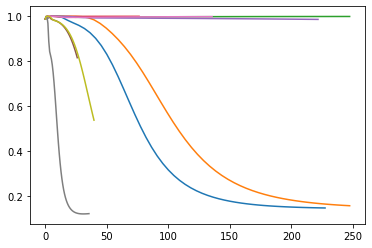

In [451]:
target_label_index = 1
feature_index = 3
preds_and_grads_function = prediction_and_gradient_for_model(net)
for instance_idx in range(1, 10):
    igs, preds, scaled_inps = get_attribution_info_details(first_input_tensor, instance_idx, target_label_index, preds_and_grads_function)
    plt.plot(scaled_inps[:, feature_index], preds[:, 1])

In [57]:
def hidden_attributions(inp, target_label_index, target_neuron_index, predictions_dfdzk_dzkdy_dydx, baseline=None, steps=50):
    if baseline is None:
        baseline = 0 * inp
    assert (baseline.shape == inp.shape)
    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i) / steps) * (inp - baseline) for i in range(0, steps + 1)]
    
    predictions, dfdzk, dzkdy, dydx = predictions_dfdzk_dzkdy_dydx(scaled_inputs, target_label_index, target_neuron_index)
    
    grads = [] # 51 grads of 12
    for step in range(len(dfdzk)):
        step_dfdzk = dfdzk[step]
        step_dzkdy = dzkdy[step]
        step_dydx = dydx[step]
        grad_dzkdy = []
        for j in range(len(step_dzkdy)):
            grad_dzkdy.append(step_dzkdy[j]*step_dydx[j])
        grad_dzkdy = np.array(grad_dzkdy)
        step_grad = step_dfdzk * grad_dzkdy
        grads.append(step_grad)
    grads = np.array(grads)
    
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = np.average(grads, axis=0)
    
    integrated_gradients = (inp.detach().numpy() - baseline.detach().numpy())*avg_grads
    integrated_gradients = integrated_gradients.sum(axis=-1)
    return integrated_gradients #predictions,

In [58]:
def ig_sigmoid2_sigmoid1(input_ts, target_label_index, target_neuron_index):
    def predictions_and_gradients_from_layers(model):
        def predictions_and_gradients(inputs, target_label_index, target_neuron_index):
            '''
                The inputs here are the steps of one single original input (alphas)
            '''
            model.eval()
            predictions, df_dsigmoid2ks, dsigmoid2k_dsigmod1s, dsigmoid1_dxs = ([], [], [], [])
            for inp in inputs:
                inp.requires_grad_(True)
                sigmoid1 = model.sigmoid1(model.linear1(inp))
                dsigmoid1_dx = []
                for j in range(sigmoid1.shape[1]):
                    sigmoid1j = sigmoid1[0, j]
                    dsigmoid1j_dx = torch.autograd.grad(sigmoid1j, inp, retain_graph=True)[0][0]
                    dsigmoid1_dx.append(dsigmoid1j_dx.detach().numpy())
                dsigmoid1_dxs.append(dsigmoid1_dx)
                
                sigmoid1.requires_grad_(True)
                sigmoid2 = model.sigmoid2(model.linear2(sigmoid1))
                
                sigmoid2k = sigmoid2[0, target_neuron_index]
                dsigmoid2k_dsigmoid1 = torch.autograd.grad(sigmoid2k, sigmoid1)[0][0]
                
                dsigmoid2k_dsigmod1s.append(dsigmoid2k_dsigmoid1.detach().numpy())
                
                f = model.softmax(model.linear3(sigmoid2))[0, target_label_index]

                df_dsigmoid2k = torch.autograd.grad(f, sigmoid2)[0][0, target_neuron_index]
                
                df_dsigmoid2ks.append(df_dsigmoid2k.detach().numpy())
                predictions.append(f.detach().numpy())
            return np.array(predictions), np.array(df_dsigmoid2ks), np.array(dsigmoid2k_dsigmod1s), np.array(dsigmoid1_dxs)
        return predictions_and_gradients
    f = predictions_and_gradients_from_layers(net)
    return hidden_attributions(input_ts, target_label_index, target_neuron_index, f, baseline=None, steps=50)

In [59]:
first_test_input_ts = test_input_tensor[0].unsqueeze(0)
# dfdzk * dzkdy * dydxi

In [60]:
ig_sigmoid2_sigmoid1(first_test_input_ts, target_label_index=1, target_neuron_index=2)

array([3.76455049e-04, 1.53041095e-03, 7.33239064e-03, 6.02228381e-03,
       1.29443435e-02, 4.25221806e-05, 8.65924463e-04, 5.83746412e-04],
      dtype=float32)

In [32]:
def ig_sigmoid2_sigmoid1_for_all_inputs(inputs_ts, target_label_index, target_neuron_index):
    results = []
    for input_ts in inputs_ts:
        input_ts = input_ts.unsqueeze(0)
        results.append(ig_sigmoid2_sigmoid1(input_ts, target_label_index, target_neuron_index))
#         import pdb
#         pdb.set_trace()
    return np.array(results)

Attribution of sigmoid1 on sigmoid2 target neuron 0
0 :  -0.036
1 :  0.006
2 :  0.008
3 :  0.006
4 :  0.007
5 :  -0.080
6 :  0.011
7 :  -0.002


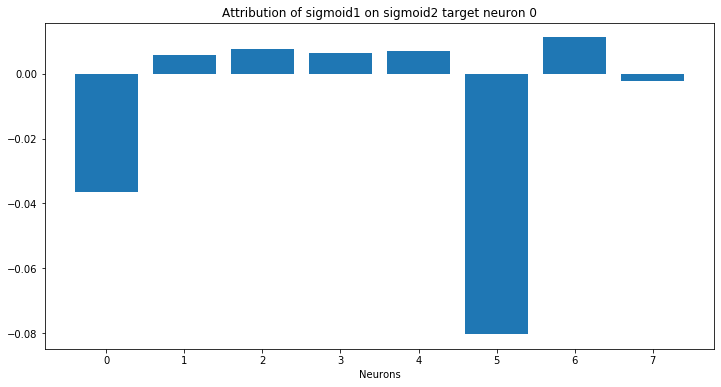

In [33]:
target_neuron = 0
target_label = 1
results = ig_sigmoid2_sigmoid1_for_all_inputs(test_input_tensor, target_label_index=target_label, target_neuron_index=target_neuron)
visualize_importances(np.arange(8), results.mean(axis=0), title=f'Attribution of sigmoid1 on sigmoid2 target neuron {target_neuron}', axis_title='Neurons')

Attribution of sigmoid1 on sigmoid2 target neuron 0
0 :  0.036
1 :  -0.006
2 :  -0.008
3 :  -0.006
4 :  -0.007
5 :  0.080
6 :  -0.011
7 :  0.002


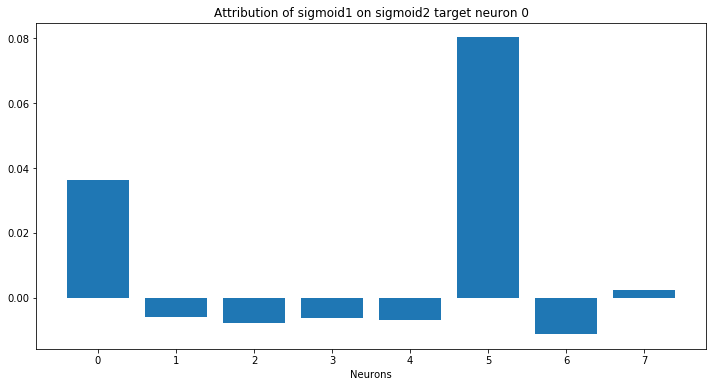

In [34]:
target_neuron = 0
target_label = 0
results = ig_sigmoid2_sigmoid1_for_all_inputs(test_input_tensor, target_label_index=target_label, target_neuron_index=target_neuron)
visualize_importances(np.arange(8), results.mean(axis=0), title=f'Attribution of sigmoid1 on sigmoid2 target neuron {target_neuron}', axis_title='Neurons')

In [35]:
def ig_of_output_for_layer(model, layer, target=1):
    layer_cond = LayerConductance(model, layer)
    layer_cond_vals = layer_cond.attribute(test_input_tensor,target=target)
    layer_cond_vals = layer_cond_vals.detach().numpy()
    return layer_cond_vals

In [36]:
def ig_of_output_for_inputs(model, target=1):
    ig = IntegratedGradients(model)
    test_input_tensor.requires_grad_()
    attr, delta = ig.attribute(test_input_tensor,target=target, return_convergence_delta=True)
    attr = attr.detach().numpy()
    return attr

# Exploring the attributions

In [245]:
ig = IntegratedGradients(net)

In [246]:
ig.attribute?

# Attribution calculations

In [179]:
# The data structure will be target_layer, target_neuron, source_layer, source_neuron,  attribution
data = []
data_individuals = []
def create_new_item(target_layer, target_neuron, source_layer, source_neuron, target_label, attribution, individual_attributions):
    return {
        'target_layer': target_layer, 
        'target_neuron': target_neuron, 
        'source_layer': source_layer, 
        'source_neuron': source_neuron, 
        'target_label': target_label,
        'attribution': attribution,
        'individual_attributions': individual_attributions
    }
def add_new_item(target_layer, target_neuron, source_layer, source_neuron, target_label, attribution, individual_attributions):
    data.append(create_new_item(target_layer, target_neuron, source_layer, source_neuron, target_label, attribution, individual_attributions))

Attribute of output target neuron 0 on sigmoid2
0 :  0.081
1 :  0.138
2 :  0.152
3 :  0.101
4 :  0.103
5 :  0.096


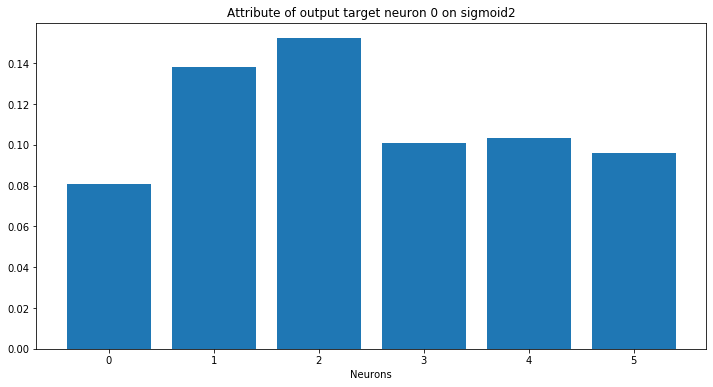

In [180]:
# sigmoid2 to outut label 0
target_neuron = target_label = 0
individual_attributions = ig_of_output_for_layer(net, net.sigmoid2, target=target_label)
results = individual_attributions.mean(axis=0)
visualize_importances(np.arange(6), results, title=f'Attribute of output target neuron {target_neuron} on sigmoid2', axis_title='Neurons')
# Add the mean result
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'sigmoid2', i, target_label, ret, individual_attributions[:, i])

In [181]:
data[0]

{'target_layer': 'output',
 'target_neuron': 0,
 'source_layer': 'sigmoid2',
 'source_neuron': 0,
 'target_label': 0,
 'attribution': 0.08067336,
 'individual_attributions': array([-0.00219384,  0.09449624,  0.09289595, -0.00205003, -0.00223289,
        -0.00058981,  0.01826768, -0.00219681,  0.09056337,  0.04971107,
        -0.00434844, -0.00277044,  0.09094695, -0.00215235, -0.00216477,
        -0.00174431, -0.00217756, -0.00226322,  0.08941367,  0.09210243,
         0.08980652, -0.00219591, -0.00235973, -0.00220753, -0.00196341,
        -0.00198894, -0.00226537, -0.00216436,  0.0887945 , -0.00235159,
        -0.00246033,  0.01499266, -0.0022974 ,  0.0911741 , -0.00239152,
         0.09062187,  0.06984888,  0.08989555,  0.0903284 ,  0.09094054,
        -0.0028307 , -0.00246203,  0.09145204,  0.09958988, -0.00497559,
         0.03800162,  0.08927295,  0.03999605, -0.00218749,  0.08307295,
         0.03479736,  0.09196977,  0.03225976, -0.00217626,  0.0889154 ,
        -0.00241897,  0.

Attributions of sigmoid2 on output target neuron 1
0 :  -0.081
1 :  -0.138
2 :  -0.152
3 :  -0.101
4 :  -0.103
5 :  -0.096


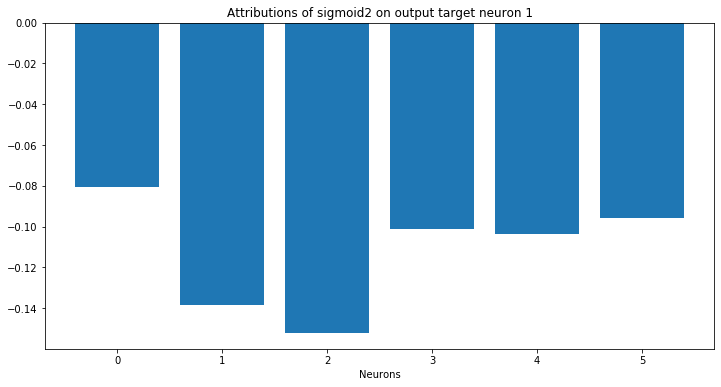

In [182]:
# sigmoid2 to output label 1
target_neuron = 1
target_label = 1
individual_attributions = ig_of_output_for_layer(net, net.sigmoid2, target=target_neuron)
results = individual_attributions.mean(axis=0)
visualize_importances(np.arange(6), results, title=f'Attributions of sigmoid2 on output target neuron {target_neuron}', axis_title='Neurons')
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'sigmoid2', i, target_label, ret, individual_attributions[:, i])

Attributions of sigmoid1 on output target neuron 0
0 :  0.300
1 :  -0.018
2 :  -0.074
3 :  -0.042
4 :  -0.038
5 :  0.601
6 :  -0.080
7 :  0.018


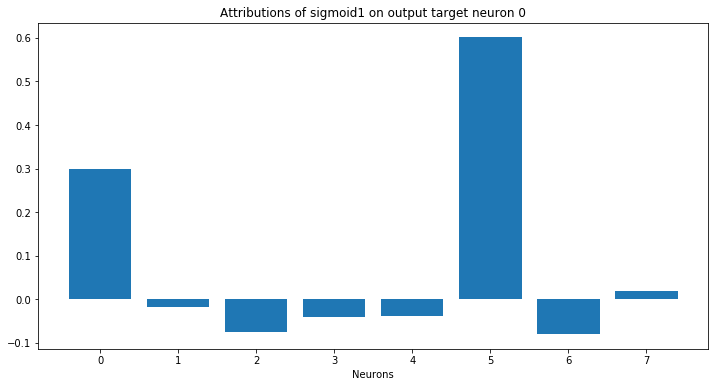

In [183]:
# Output label 0 to sigmoid 1
target_neuron = 0
target_label = 0
individual_attributions = ig_of_output_for_layer(net, net.sigmoid1, target=target_neuron)
results = individual_attributions.mean(axis=0)
visualize_importances(np.arange(8), results, title=f'Attributions of sigmoid1 on output target neuron {target_neuron}', axis_title='Neurons')
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'sigmoid1', i, target_label, ret, individual_attributions[:, i])

Attribute of sigmoid1 on target neuron 1
0 :  -0.300
1 :  0.018
2 :  0.074
3 :  0.042
4 :  0.038
5 :  -0.601
6 :  0.080
7 :  -0.018


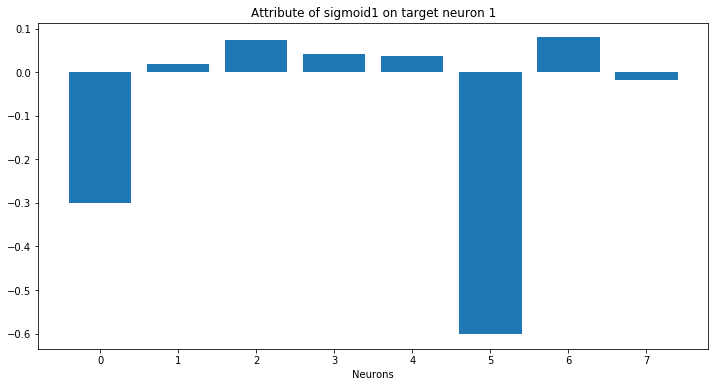

In [184]:
# Output label 1 to layer 1
target_neuron = 1
target_label = 1
individual_attributions = ig_of_output_for_layer(net, net.sigmoid1, target=target_neuron)
results = individual_attributions.mean(axis=0)
visualize_importances(np.arange(8), results, title=f'Attribute of sigmoid1 on target neuron {target_neuron}', axis_title='Neurons')
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'sigmoid1', i, target_label, ret, individual_attributions[:, i])

Attribution of inputs on output target neuron 0
age :  1.065
sibsp :  0.106
parch :  0.061
fare :  -0.541
female :  -0.305
male :  0.242
embark_C :  -0.096
embark_Q :  -0.001
embark_S :  0.029
class_1 :  -0.076
class_2 :  -0.058
class_3 :  0.265


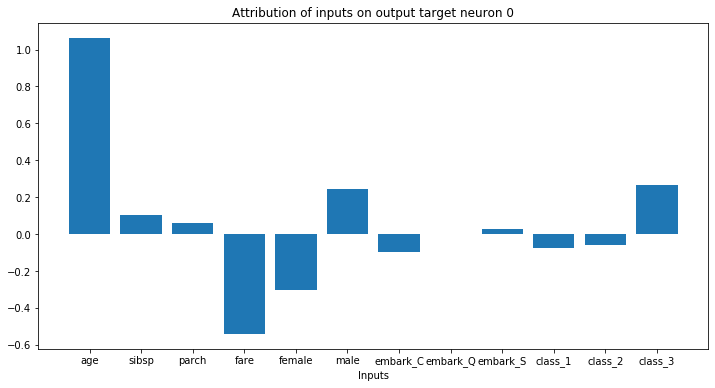

In [185]:
# Attributions of inputs to output
target_neuron = 0
target_label = 0
individual_attributions = ig_of_output_for_inputs(net, target=target_neuron)
results = individual_attributions.mean(axis=0)
visualize_importances(feature_names, results, title=f'Attribution of inputs on output target neuron {target_neuron}', axis_title='Inputs')
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'input', i, target_label, ret, individual_attributions[:, i])

Attribution of inputs on output target neuron 1
age :  -1.065
sibsp :  -0.106
parch :  -0.061
fare :  0.541
female :  0.305
male :  -0.242
embark_C :  0.096
embark_Q :  0.001
embark_S :  -0.029
class_1 :  0.076
class_2 :  0.058
class_3 :  -0.265


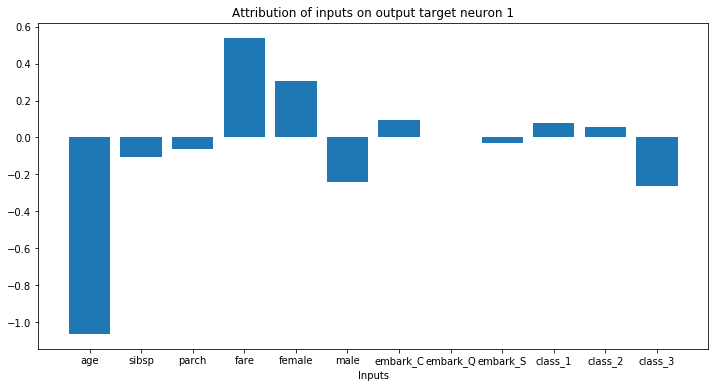

In [186]:
# Attributions of inputs to output
target_neuron = 1
target_label = 1
individual_attributions = ig_of_output_for_inputs(net, target=target_neuron)
results = individual_attributions.mean(axis=0)
visualize_importances(feature_names, results, title=f'Attribution of inputs on output target neuron {target_neuron}', axis_title='Inputs')
for i, ret in enumerate(results):
    add_new_item('output', target_neuron, 'input', i, target_label, ret, individual_attributions[:, i])

In [187]:
len(data)

52

# Now for sigmoid2 back

Attribution of sigmoid1 on sigmoid2 target neuron 0, target label 0
0 :  0.036
1 :  -0.006
2 :  -0.008
3 :  -0.006
4 :  -0.007
5 :  0.080
6 :  -0.011
7 :  0.002
Attribution of sigmoid1 on sigmoid2 target neuron 1, target label 0
0 :  0.053
1 :  -0.002
2 :  -0.017
3 :  -0.007
4 :  -0.009
5 :  0.138
6 :  -0.018
7 :  0.003
Attribution of sigmoid1 on sigmoid2 target neuron 2, target label 0
0 :  0.075
1 :  -0.007
2 :  -0.022
3 :  -0.015
4 :  -0.011
5 :  0.153
6 :  -0.021
7 :  0.004
Attribution of sigmoid1 on sigmoid2 target neuron 3, target label 0
0 :  0.047
1 :  -0.001
2 :  -0.013
3 :  -0.007
4 :  -0.008
5 :  0.094
6 :  -0.013
7 :  0.002
Attribution of sigmoid1 on sigmoid2 target neuron 4, target label 0
0 :  0.045
1 :  -0.001
2 :  -0.012
3 :  -0.005
4 :  -0.006
5 :  0.092
6 :  -0.010
7 :  0.002
Attribution of sigmoid1 on sigmoid2 target neuron 5, target label 0
0 :  0.045
1 :  -0.004
2 :  -0.010
3 :  -0.007
4 :  -0.007
5 :  0.089
6 :  -0.011
7 :  0.002
Attribution of sigmoid1 on sigmoid

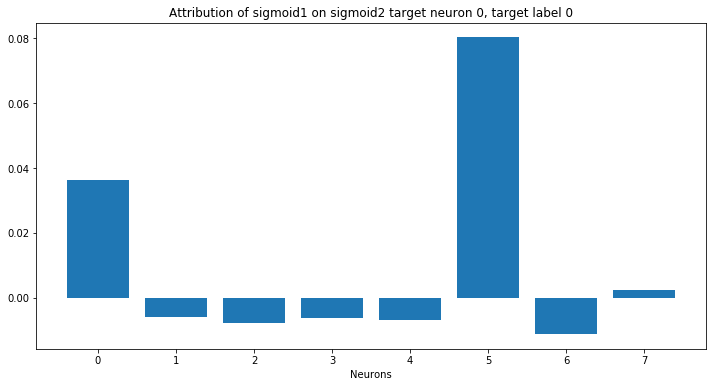

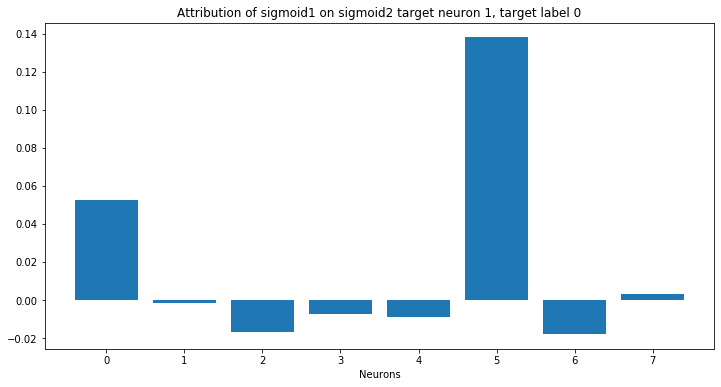

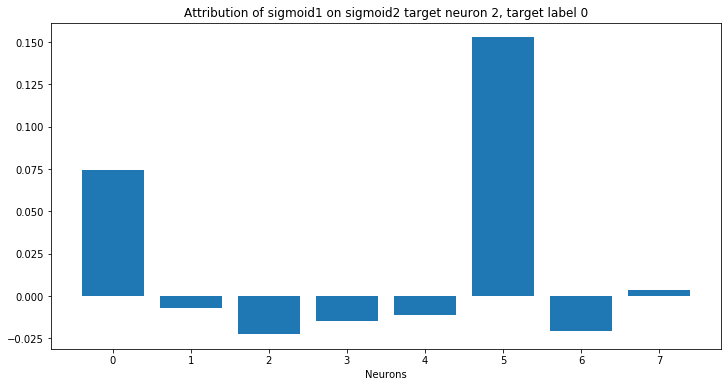

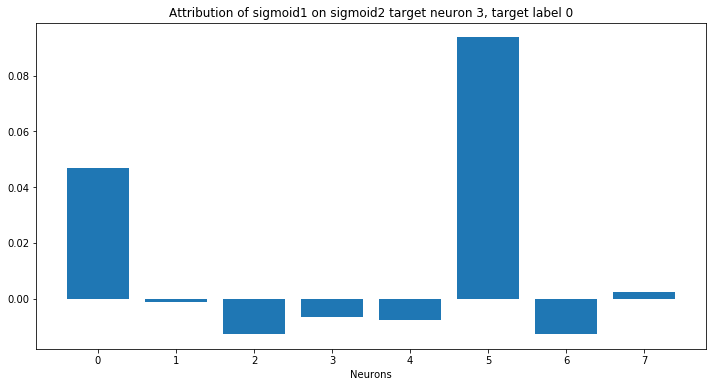

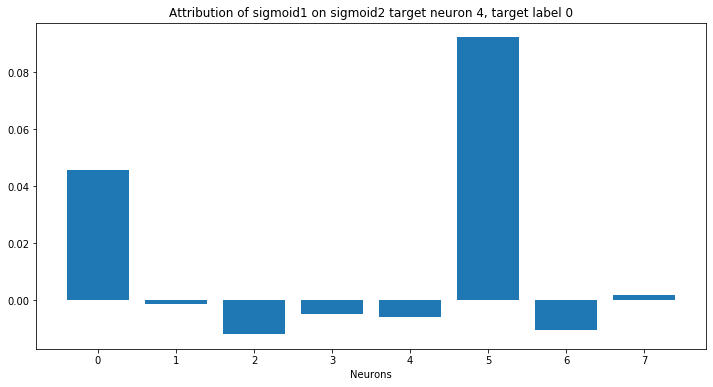

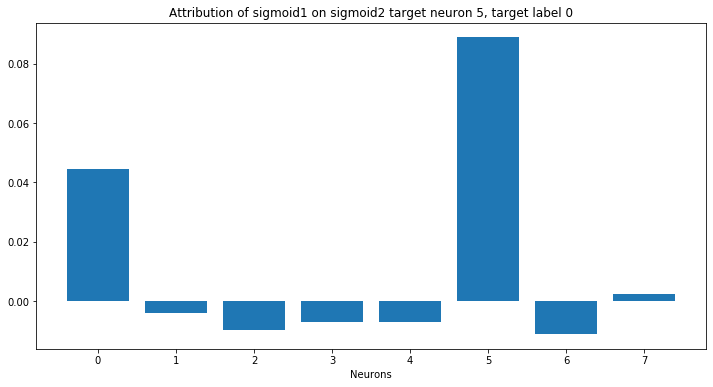

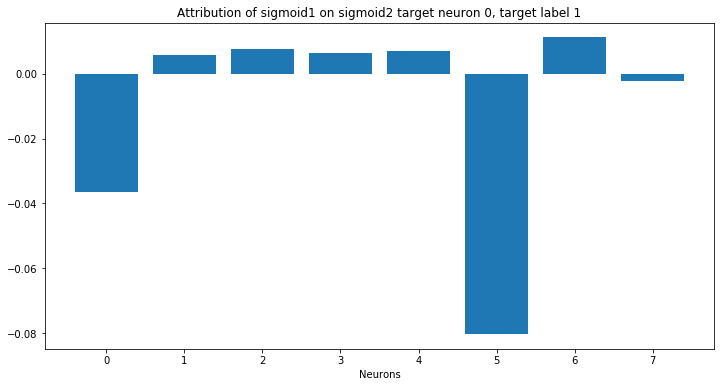

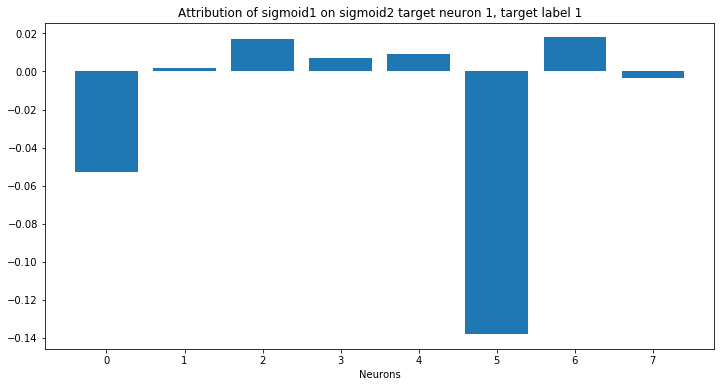

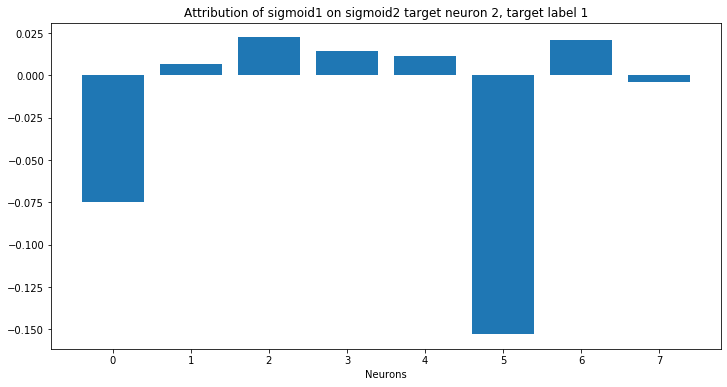

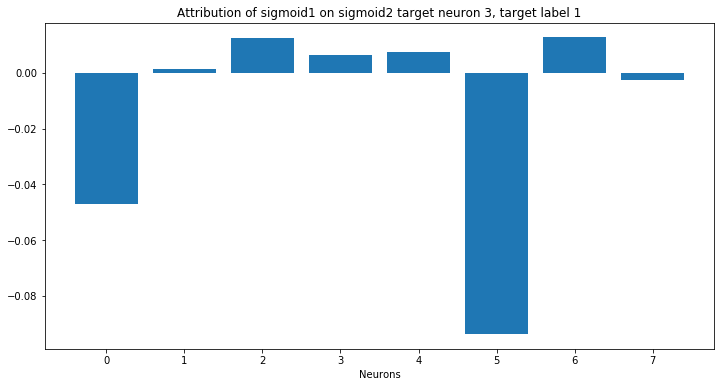

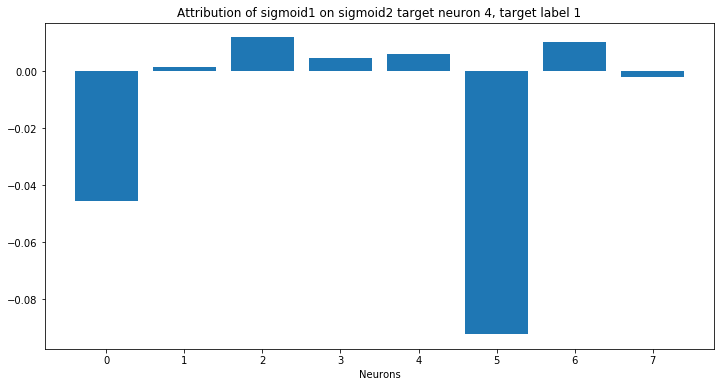

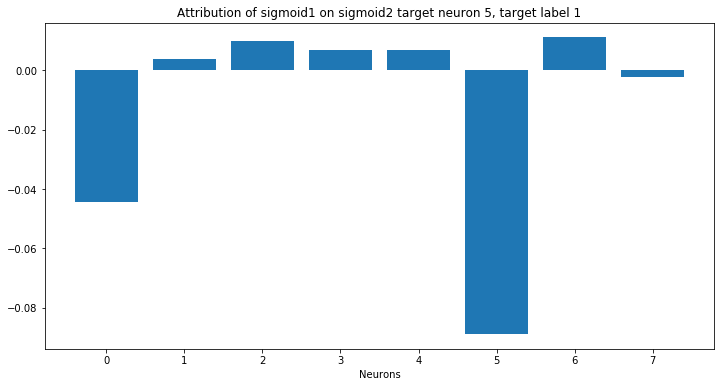

In [188]:
for target_label in range(2):
    for target_neuron in range(6):
        individual_attributions = ig_sigmoid2_sigmoid1_for_all_inputs(test_input_tensor, target_label_index=target_label, target_neuron_index=target_neuron)
        results = individual_attributions.mean(axis=0)
        visualize_importances(np.arange(8), results, title=f'Attribution of sigmoid1 on sigmoid2 target neuron {target_neuron}, target label {target_label}', axis_title='Neurons')
        for i, ret in enumerate(results):
            add_new_item('sigmoid2', target_neuron, 'sigmoid1', i, target_label, ret, individual_attributions[:, i])

In [189]:
len(data)

148

In [190]:
def input_attribuions_to_layer(model, layer, target_label, target_neuron):
    neuron_cond = NeuronConductance(model, layer)
    individual_attributions = neuron_cond.attribute(test_input_tensor, neuron_index=target_neuron, target=target_label).detach().numpy()
    return individual_attributions

Attribution of input on sigmoid2 target neuron 0
age :  0.135
sibsp :  0.015
parch :  0.008
fare :  -0.077
female :  -0.038
male :  0.030
embark_C :  -0.012
embark_Q :  -0.000
embark_S :  0.003
class_1 :  -0.009
class_2 :  -0.008
class_3 :  0.032
Attribution of input on sigmoid2 target neuron 1
age :  0.210
sibsp :  0.023
parch :  0.013
fare :  -0.104
female :  -0.056
male :  0.043
embark_C :  -0.018
embark_Q :  0.000
embark_S :  0.004
class_1 :  -0.014
class_2 :  -0.012
class_3 :  0.049
Attribution of input on sigmoid2 target neuron 2
age :  0.245
sibsp :  0.025
parch :  0.015
fare :  -0.134
female :  -0.073
male :  0.058
embark_C :  -0.023
embark_Q :  -0.000
embark_S :  0.007
class_1 :  -0.018
class_2 :  -0.014
class_3 :  0.064
Attribution of input on sigmoid2 target neuron 3
age :  0.159
sibsp :  0.016
parch :  0.009
fare :  -0.084
female :  -0.046
male :  0.037
embark_C :  -0.014
embark_Q :  -0.000
embark_S :  0.005
class_1 :  -0.012
class_2 :  -0.009
class_3 :  0.040
Attribution o

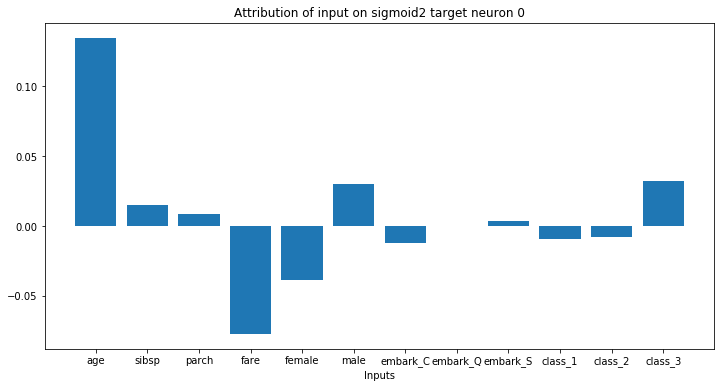

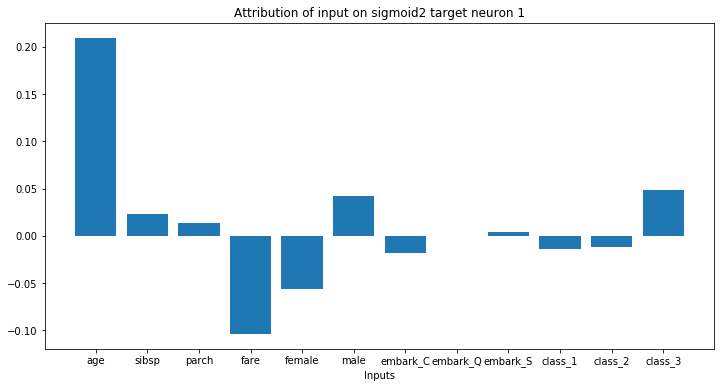

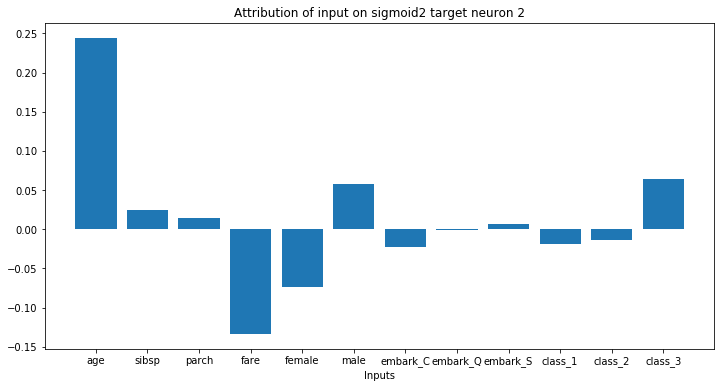

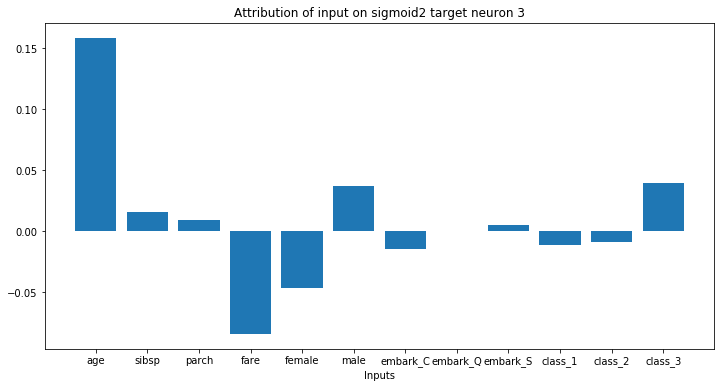

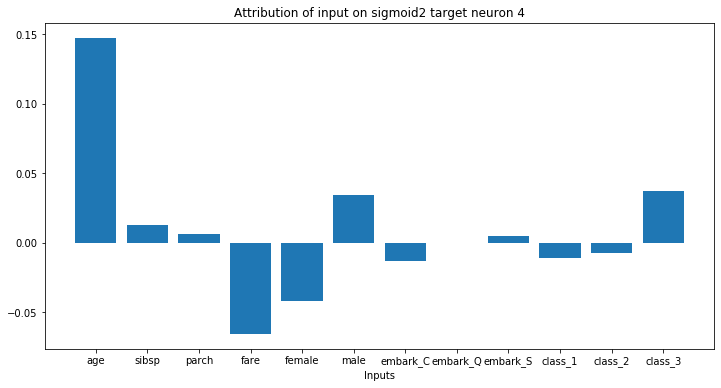

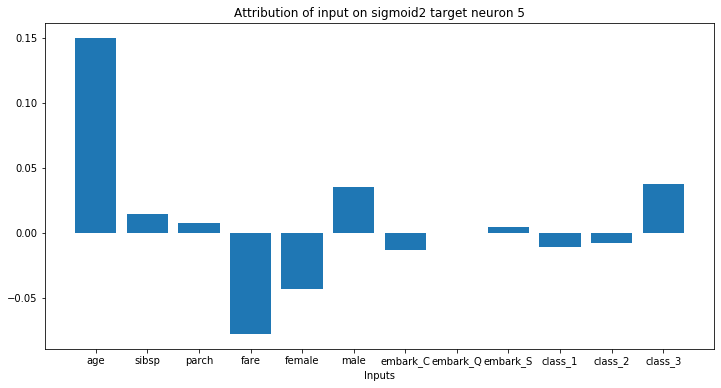

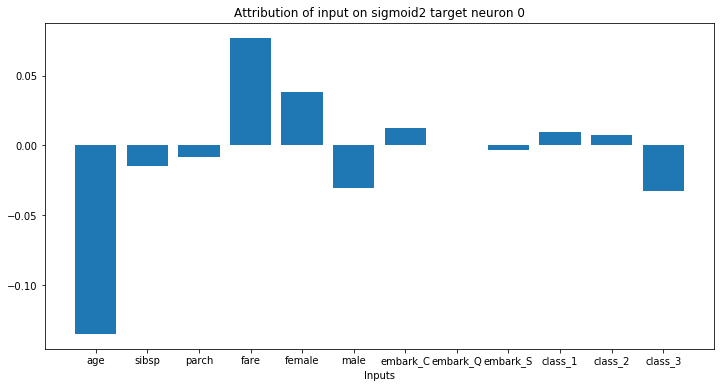

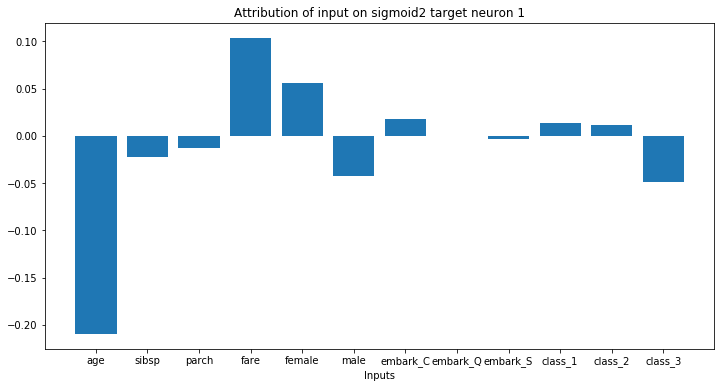

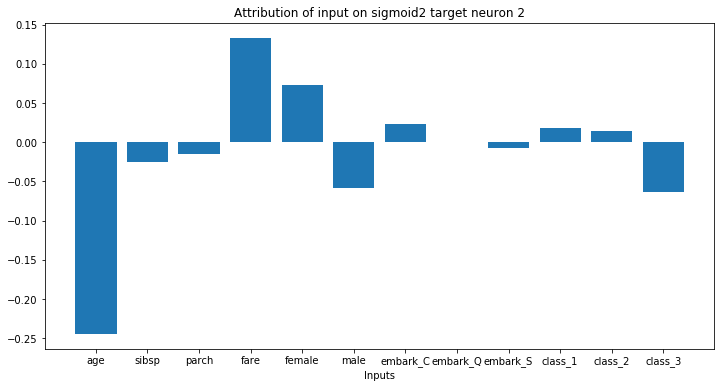

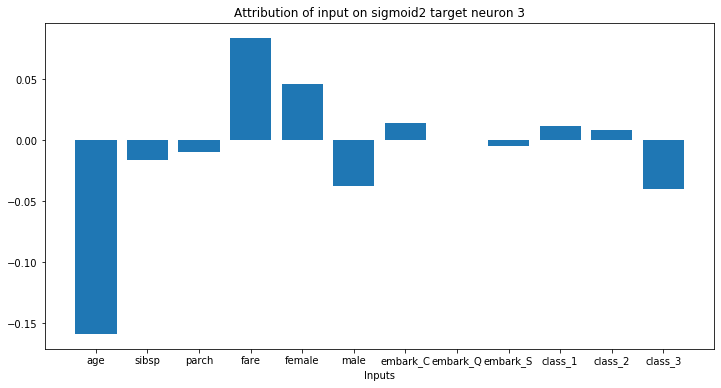

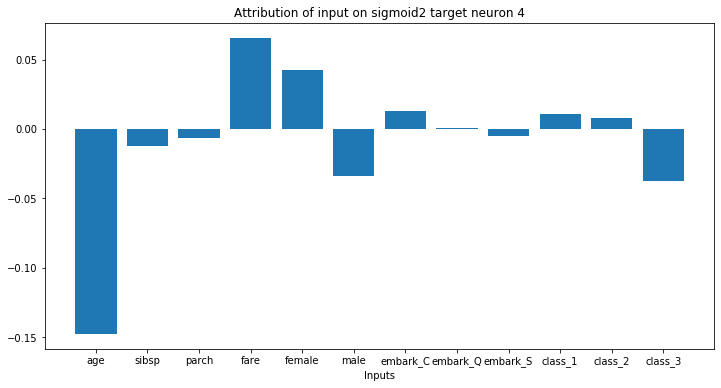

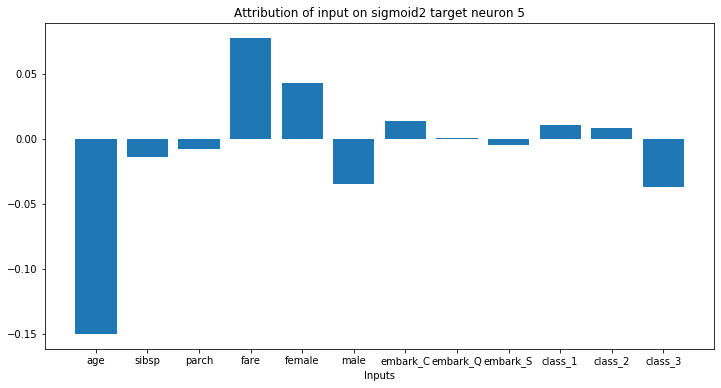

In [191]:
# Attributions of inputs on sigmoid2 (6 neurons)
for target_label in range(2):
    for target_neuron in range(6):
        individual_attributions = input_attribuions_to_layer(net, net.sigmoid2, target_label, target_neuron)
        results = individual_attributions.mean(axis=0)
        visualize_importances(feature_names, results, title=f'Attribution of input on sigmoid2 target neuron {target_neuron}', axis_title='Inputs')
        for i, ret in enumerate(results):
            add_new_item('sigmoid2', target_neuron, 'input', i, target_label, ret, individual_attributions[:, i])

Attribution of input on sigmoid1 target neuron 0, target label 0
age :  0.200
sibsp :  -0.027
parch :  -0.021
fare :  0.046
female :  -0.172
male :  0.177
embark_C :  -0.043
embark_Q :  -0.004
embark_S :  0.045
class_1 :  -0.056
class_2 :  -0.004
class_3 :  0.153
Attribution of input on sigmoid1 target neuron 1, target label 0
age :  -0.014
sibsp :  -0.000
parch :  0.000
fare :  -0.006
female :  0.000
male :  -0.000
embark_C :  -0.000
embark_Q :  0.000
embark_S :  -0.000
class_1 :  -0.000
class_2 :  0.000
class_3 :  -0.000
Attribution of input on sigmoid1 target neuron 2, target label 0
age :  -0.028
sibsp :  0.000
parch :  -0.001
fare :  -0.054
female :  -0.002
male :  0.005
embark_C :  -0.001
embark_Q :  -0.002
embark_S :  0.002
class_1 :  0.000
class_2 :  -0.001
class_3 :  0.001
Attribution of input on sigmoid1 target neuron 3, target label 0
age :  -0.010
sibsp :  0.000
parch :  -0.000
fare :  -0.036
female :  -0.001
male :  0.003
embark_C :  -0.001
embark_Q :  -0.001
embark_S :  0

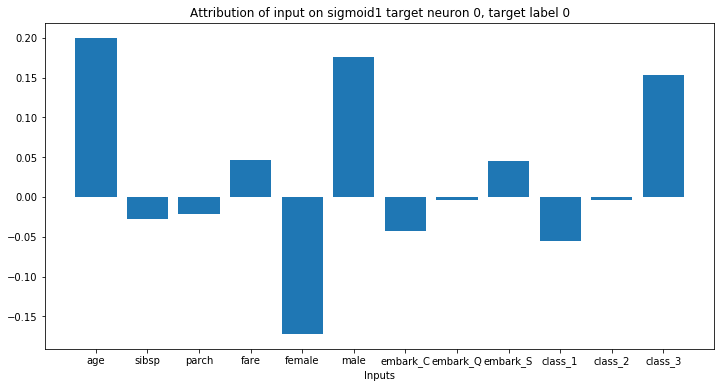

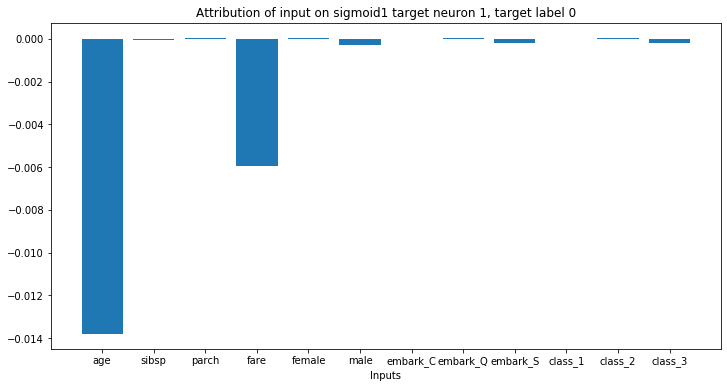

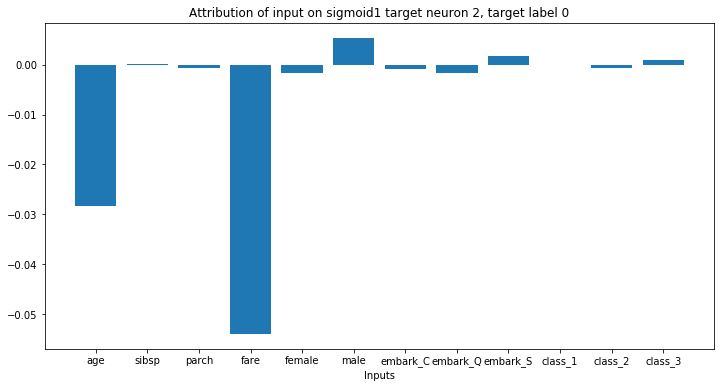

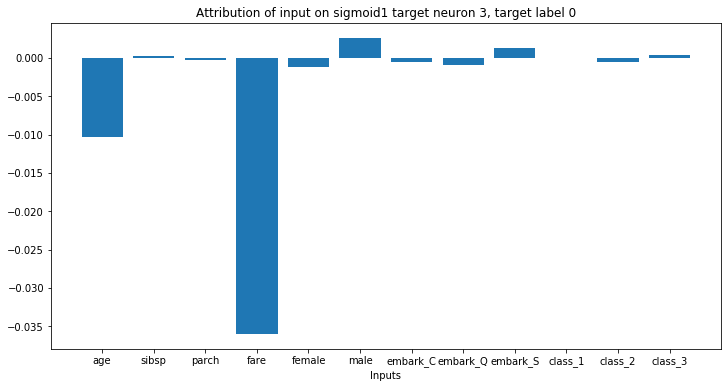

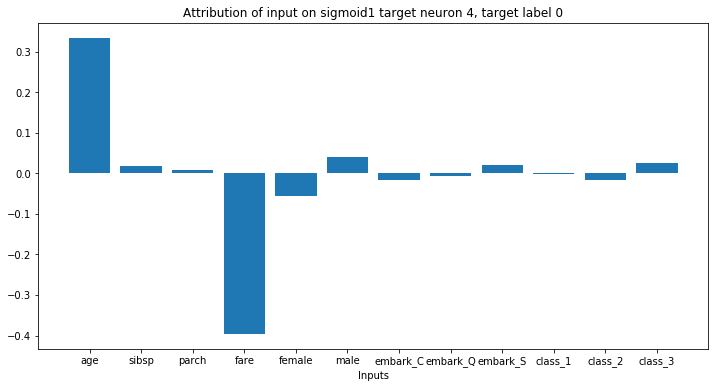

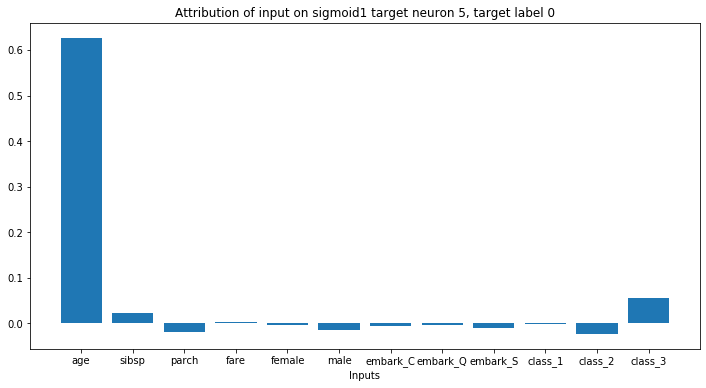

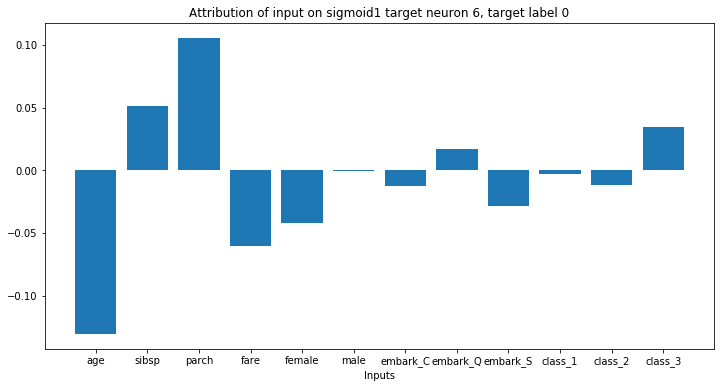

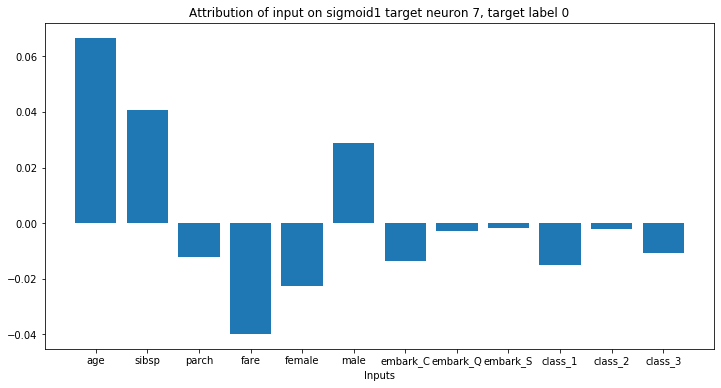

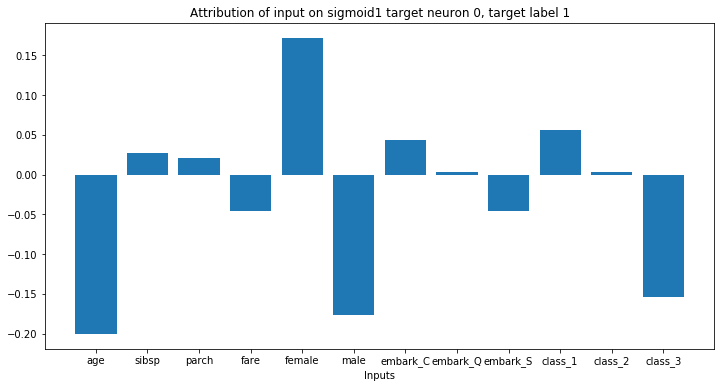

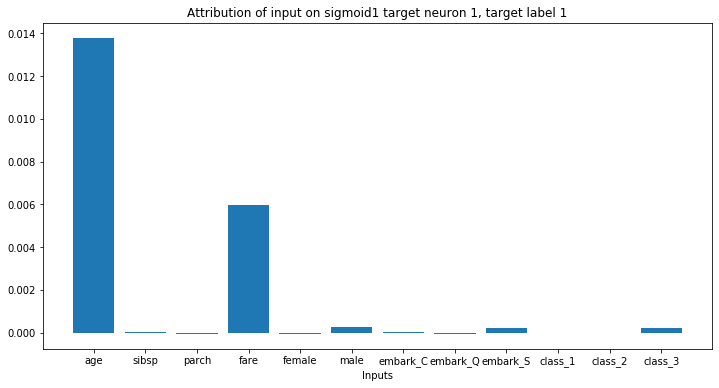

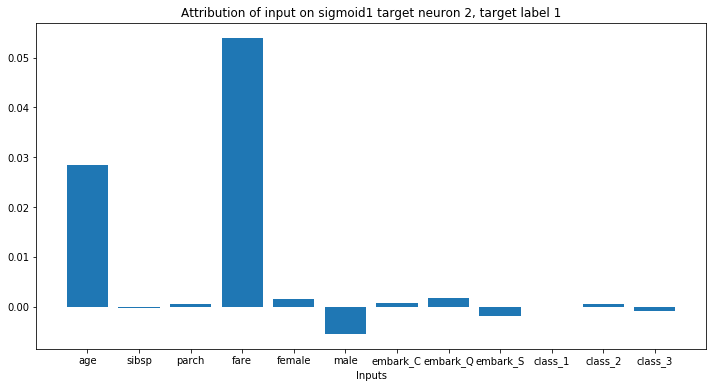

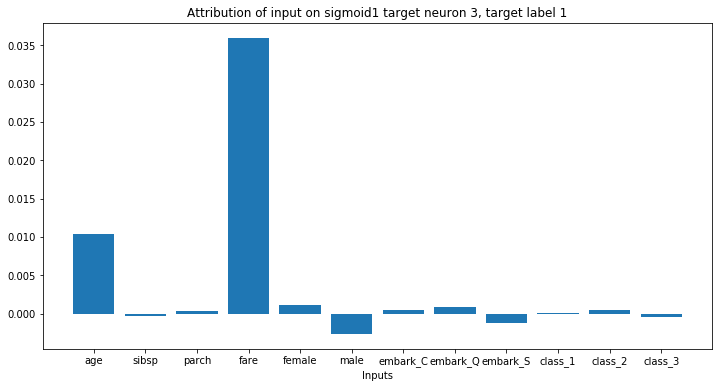

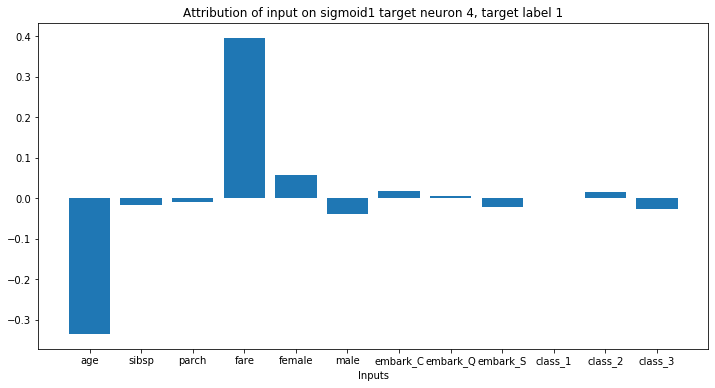

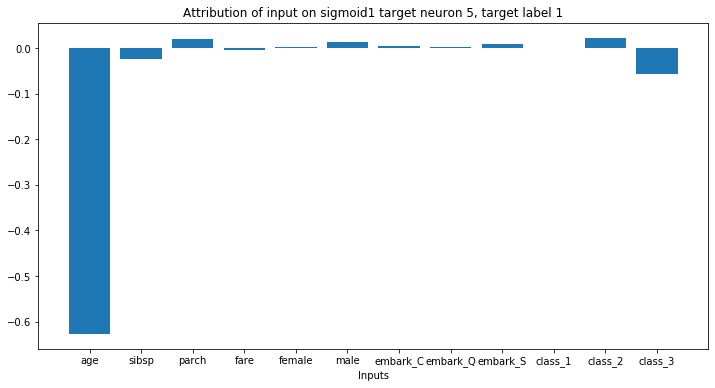

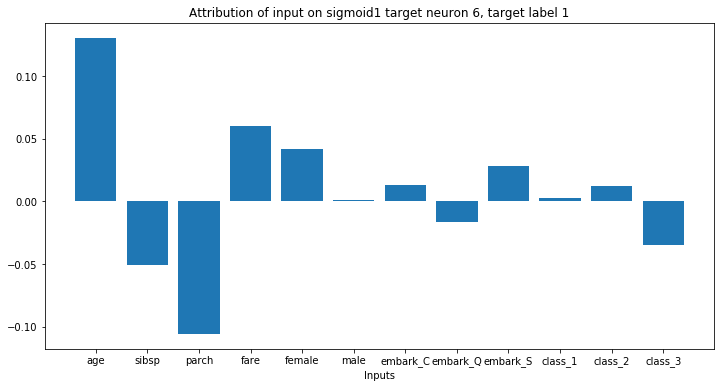

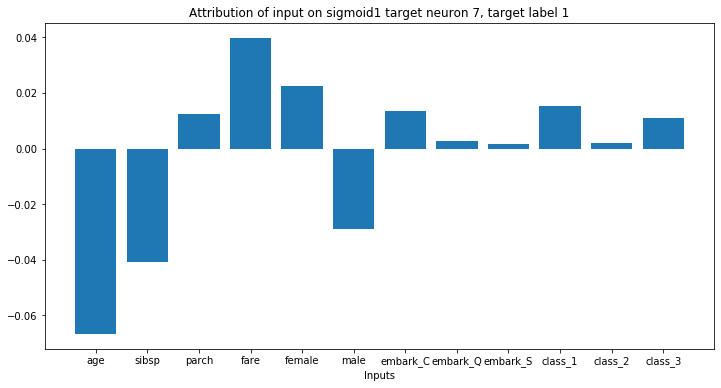

In [192]:
# Attributions of inputs on sigmoid1 (8 neurons)
for target_label in range(2):
    for target_neuron in range(8):
        individual_attributions = input_attribuions_to_layer(net, net.sigmoid1, target_label, target_neuron)
        results = individual_attributions.mean(axis=0)
        visualize_importances(feature_names, results, title=f'Attribution of input on sigmoid1 target neuron {target_neuron}, target label {target_label}', axis_title='Inputs')
        for i, ret in enumerate(results):
            add_new_item('sigmoid1', target_neuron, 'input', i, target_label, ret, individual_attributions[:, i])

In [193]:
len(data)

484

In [194]:
import json

In [195]:
data[0]['individual_attributions'].tolist()

[-0.002193843014538288,
 0.0944962352514267,
 0.09289594739675522,
 -0.0020500309765338898,
 -0.002232892205938697,
 -0.0005898083909414709,
 0.018267683684825897,
 -0.002196813467890024,
 0.09056337177753448,
 0.04971107468008995,
 -0.004348442889750004,
 -0.002770438324660063,
 0.09094695001840591,
 -0.002152347471565008,
 -0.002164773643016815,
 -0.0017443097895011306,
 -0.0021775641944259405,
 -0.002263216068968177,
 0.08941367268562317,
 0.09210243076086044,
 0.08980651944875717,
 -0.0021959079895168543,
 -0.00235973228700459,
 -0.00220753182657063,
 -0.001963413320481777,
 -0.001988944597542286,
 -0.002265365095809102,
 -0.0021643636282533407,
 0.08879449963569641,
 -0.0023515895009040833,
 -0.002460325602442026,
 0.014992663636803627,
 -0.002297396771609783,
 0.09117409586906433,
 -0.002391523914411664,
 0.09062187373638153,
 0.06984888017177582,
 0.08989554643630981,
 0.0903283953666687,
 0.09094053506851196,
 -0.002830695826560259,
 -0.0024620345793664455,
 0.09145203977823257

# Dumping data

In [196]:
# attribution data
with open('titanic_data.json', 'w') as f:
    for item in data:
        item['attribution'] = float(item['attribution'])
        item['individual_attributions'] = item['individual_attributions'].tolist()
    json.dump(data, f)

In [197]:
feature_names

['age',
 'sibsp',
 'parch',
 'fare',
 'female',
 'male',
 'embark_C',
 'embark_Q',
 'embark_S',
 'class_1',
 'class_2',
 'class_3']

In [198]:
net.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0831, -0.8036, -0.6936,  0.0206, -4.5971,  4.3829, -2.5739, -0.3320,
                        0.9034, -2.9027, -0.3622,  3.1919],
                      [ 0.6137,  0.1746, -0.4433,  0.7070, -0.3327,  0.4398,  0.1937, -0.4587,
                        0.3653,  0.1005, -0.4527,  0.2955],
                      [ 0.2040, -0.2137,  1.5273,  1.1062,  1.4442, -1.4837,  1.2804,  2.1775,
                       -0.5295, -0.0458,  0.8828, -0.2193],
                      [-0.1192,  0.4142, -1.5086, -1.2034, -1.5414,  1.1803, -1.3722, -1.7169,
                        0.6089, -1.1318, -1.2061,  0.1449],
                      [ 0.4102,  3.1289,  2.1363, -1.4273, -3.6105,  3.3926, -6.3084, -0.9472,
                        1.1385, -1.2693, -5.1445,  1.0605],
                      [-1.6493, -3.2816,  4.7553, -0.0202,  1.0445,  1.2985,  3.5032,  1.5226,
                        0.9669,  1.5017,  7.9761, -5.1985],
                      [-0.1362,  1.896

In [199]:
sd = net.state_dict()
network_weights = [{item: sd[item].detach().numpy().tolist()} for item in sd]

In [200]:
network_weights

[{'linear1.weight': [[0.08305900543928146,
    -0.8036120533943176,
    -0.693565845489502,
    0.020554937422275543,
    -4.597103595733643,
    4.382890701293945,
    -2.5739219188690186,
    -0.3320337235927582,
    0.9034051299095154,
    -2.902682304382324,
    -0.36224913597106934,
    3.1919074058532715],
   [0.6137447357177734,
    0.17461666464805603,
    -0.4433283507823944,
    0.7070423364639282,
    -0.3326530456542969,
    0.4398345649242401,
    0.1936839520931244,
    -0.4587295949459076,
    0.3653120696544647,
    0.10048045217990875,
    -0.45267632603645325,
    0.2954711318016052],
   [0.20401233434677124,
    -0.21369343996047974,
    1.5273010730743408,
    1.1061753034591675,
    1.4441698789596558,
    -1.4837359189987183,
    1.2804023027420044,
    2.1775338649749756,
    -0.5294609069824219,
    -0.045842818915843964,
    0.8827532529830933,
    -0.21925897896289825],
   [-0.11924407631158829,
    0.41423681378364563,
    -1.5086493492126465,
    -1.20339834

In [201]:
with open('network_weights.json', 'w') as f:
    json.dump(network_weights, f)

In [202]:
data[0]

{'target_layer': 'output',
 'target_neuron': 0,
 'source_layer': 'sigmoid2',
 'source_neuron': 0,
 'target_label': 0,
 'attribution': 0.08067335933446884,
 'individual_attributions': [-0.002193843014538288,
  0.0944962352514267,
  0.09289594739675522,
  -0.0020500309765338898,
  -0.002232892205938697,
  -0.0005898083909414709,
  0.018267683684825897,
  -0.002196813467890024,
  0.09056337177753448,
  0.04971107468008995,
  -0.004348442889750004,
  -0.002770438324660063,
  0.09094695001840591,
  -0.002152347471565008,
  -0.002164773643016815,
  -0.0017443097895011306,
  -0.0021775641944259405,
  -0.002263216068968177,
  0.08941367268562317,
  0.09210243076086044,
  0.08980651944875717,
  -0.0021959079895168543,
  -0.00235973228700459,
  -0.00220753182657063,
  -0.001963413320481777,
  -0.001988944597542286,
  -0.002265365095809102,
  -0.0021643636282533407,
  0.08879449963569641,
  -0.0023515895009040833,
  -0.002460325602442026,
  0.014992663636803627,
  -0.002297396771609783,
  0.09117

In [203]:
out_classes

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [204]:
out_probs

array([[5.97459511e-05, 9.99940276e-01],
       [8.54755640e-01, 1.45244315e-01],
       [8.44737530e-01, 1.55262411e-01],
       [1.17688254e-03, 9.98823106e-01],
       [6.66187843e-04, 9.99333799e-01],
       [1.42181823e-02, 9.85781848e-01],
       [1.85041904e-01, 8.14958096e-01],
       [1.88256672e-03, 9.98117447e-01],
       [8.79993916e-01, 1.20006114e-01],
       [4.63427693e-01, 5.36572337e-01],
       [9.84107843e-04, 9.99015927e-01],
       [6.71964895e-04, 9.99328017e-01],
       [8.49721789e-01, 1.50278196e-01],
       [6.71451911e-04, 9.99328613e-01],
       [6.62571692e-04, 9.99337375e-01],
       [2.05265805e-02, 9.79473412e-01],
       [6.65888481e-04, 9.99334037e-01],
       [6.63364714e-04, 9.99336660e-01],
       [8.56709480e-01, 1.43290520e-01],
       [8.64878714e-01, 1.35121360e-01],
       [8.55808377e-01, 1.44191593e-01],
       [3.07859882e-04, 9.99692202e-01],
       [6.77511212e-04, 9.99322534e-01],
       [6.63868093e-04, 9.99336064e-01],
       [7.571201

In [205]:
np.argsort(out_probs[:, 0])

array([129,   0, 150,  86, 165, 257,  21, 140,  27,  53,  14, 131,  61,
        66,  17,  23,  70,  29,  16,   4,  32, 100, 123,  34,  63,  13,
        11, 101,  71,  48,  22,  55,  82, 378,  41,  30, 328,  92,  78,
        24, 115,  93, 128,  97, 164, 166, 111,  25, 146, 125,  26, 151,
       156,  99,  44,  10, 118,  94,  40,   3,  88, 152, 304, 320,  85,
         7, 110,  89, 190, 105, 219, 126, 230,   5, 200, 323,  15, 322,
        59, 311, 306, 268, 161, 388, 228, 213, 324, 308, 326, 233, 275,
       312, 305, 330, 384,  80, 207, 195, 296, 170,  31, 198,   6, 372,
        52, 293,  50,  45,  47, 130, 255,   9, 350,  64, 211,  62,  36,
        73, 216, 344, 256,  58,  79, 309,  28,  33, 329,  51,  68,   2,
       149,  12,  77,  35,  57,  81,  60,  37,  65, 253,   1,  42,  20,
       362,  18,  75,  67,  46,  76,  95, 160, 343,  38,  19, 174, 141,
       132, 113, 273,  39,   8, 189, 185, 283, 148, 258, 351, 249,  43,
       173, 142, 327,  54, 267, 266, 341,  72, 187, 288, 287, 26

In [206]:
np.sum(out_probs, axis=1)

array([1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 1.0000001 ,
       1.        , 1.0000001 , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.0000001 , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.0000001 , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.     

In [207]:
order = np.argsort(out_probs[:,0])

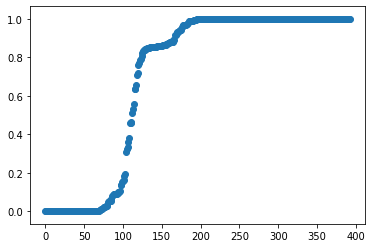

In [208]:
plt.scatter(np.arange(len(out_probs)), out_probs[:, 0][order])

In [210]:
neuron_values

{'input': [[2.0,
   1.0,
   2.0,
   151.5500030517578,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0],
  [47.0, 1.0, 0.0, 227.52499389648438, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [24.0, 0.0, 1.0, 247.5207977294922, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [50.0, 0.0, 1.0, 247.5207977294922, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [32.0, 0.0, 0.0, 76.29170227050781, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [29.0, 0.0, 0.0, 221.77920532226562, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [25.0, 0.0, 0.0, 26.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [35.0, 0.0, 0.0, 135.63330078125, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [45.0, 0.0, 0.0, 35.5, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [29.88113784790039,
   0.0,
   0.0,
   39.599998474121094,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0],
  [59.0, 2.0, 0.0, 51.47919845581055, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [53.0, 0.0, 0.0, 27.44580078125, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,

In [212]:
# # Dumping the neuron values
# neuron_values
# for k in neuron_values.keys():
#     neuron_values[k] = neuron_values[k].tolist()

In [211]:
with open('neuron_values.json', 'w') as f:
    json.dump(neuron_values, f)

In [213]:
# dumping the outputs and the actual values.
outputs = {}
outputs['predicted_class'] = out_classes.tolist()
outputs['actual_class'] = test_labels.tolist()

In [214]:
with open('predicted_vs_actual.json', 'w') as f:
    json.dump(outputs, f)

In [225]:
test_name_data = [{'name': name, 'index': i} for i, name in enumerate(test_names)]

In [226]:
test_name_data[0]

{'name': 'Allison, Miss. Helen Loraine', 'index': 0}

In [227]:
with open('names.json', 'w') as f:
    json.dump(test_name_data, f)

In [242]:
a = np.array([1, 2, 3, 4])

In [243]:
a.clip(2, 3, a)

array([2, 2, 3, 3])

In [244]:
a

array([2, 2, 3, 3])